In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2

# Function to load images from a directory and convert them to numpy arrays
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            if "COVID-" in filename:
                labels.append(1)  # COVID-19 Positive class
            elif "Normal-" in filename:
                labels.append(0)  # COVID-19 Negative class
    return images, labels

# Paths to folders containing images
covid_positive_folder = "/content/drive/MyDrive/main_project/Train/covid_positive_mask"
covid_negative_folder = "/content/drive/MyDrive/main_project/Train/covid_negative_mask"

# Load images and corresponding labels
covid_pos_images, covid_pos_labels = load_images_from_folder(covid_positive_folder)
covid_neg_images, covid_neg_labels = load_images_from_folder(covid_negative_folder)

# Convert lists to numpy arrays
covid_pos_images = np.array(covid_pos_images)
covid_neg_images = np.array(covid_neg_images)
covid_pos_labels = np.array(covid_pos_labels)
covid_neg_labels = np.array(covid_neg_labels)

# Save numpy arrays and labels to .npy files
np.save('covid_positive_images.npy', covid_pos_images)
np.save('covid_negative_images.npy', covid_neg_images)
np.save('covid_positive_labels.npy', covid_pos_labels)
np.save('covid_negative_labels.npy', covid_neg_labels)


In [ ]:
import numpy as np

# Load data
covid_positive_images = np.load('covid_positive_images.npy')
covid_negative_images = np.load('covid_negative_images.npy')
covid_positive_labels = np.load('covid_positive_labels.npy')
covid_negative_labels = np.load('covid_negative_labels.npy')

# Combine positive and negative samples
all_images = np.concatenate((covid_positive_images, covid_negative_images), axis=0)
all_labels = np.concatenate((covid_positive_labels, covid_negative_labels), axis=0)

# Debug: Print the sizes of the arrays
print(len(all_images))
print(len(all_labels))
# Shuffle indices
idx = np.arange(len(all_images))
np.random.shuffle(idx)


# Apply the permutation to shuffle the data
all_images_shuffled = all_images[idx]
all_labels_shuffled = all_labels[idx]


# Split data into training and validation sets
split = int(0.8 * len(all_images))
train_images, val_images = all_images[:split], all_images[split:]
train_labels, val_labels = all_labels[:split], all_labels[split:]


2000
2000


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from scipy import ndimage

# Load pre-trained Resnet model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

learning_rate = 0.001
# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=5)
# Define a function to resize numpy arrays
def resize_array(array, new_shape):
    return np.array([ndimage.zoom(img, (new_shape[0] / img.shape[0], new_shape[1] / img.shape[1], 1), order=1) for img in array])


# Resize input numpy arrays to match the desired shape
train_images_resized = resize_array(train_images, (224, 224))
val_images_resized = resize_array(val_images, (224, 224))

# Ensure data is in the correct format
train_images_resized = train_images_resized.astype('float32') / 255.0
val_images_resized = val_images_resized.astype('float32') / 255.0

# Now, you can fit your model with the resized numpy arrays
H = model.fit(train_images_resized, train_labels, validation_data=(val_images_resized, val_labels), epochs=10, verbose=1, callbacks=[es])


94668760/94668760 [==============================] - 3s 0us/step
Epoch 1/10
50/50 [==============================] - 404s 8s/step - loss: 3.2039 - accuracy: 0.9131 - val_loss: 0.5941 - val_accuracy: 0.9550
Epoch 2/10
50/50 [==============================] - 377s 8s/step - loss: 0.4948 - accuracy: 0.9669 - val_loss: 0.1802 - val_accuracy: 0.9925
Epoch 3/10
50/50 [==============================] - 380s 8s/step - loss: 0.5925 - accuracy: 0.9613 - val_loss: 0.1008 - val_accuracy: 0.9950
Epoch 4/10
50/50 [==============================] - 380s 8s/step - loss: 0.4965 - accuracy: 0.9706 - val_loss: 3.5166 - val_accuracy: 0.8775
Epoch 5/10
50/50 [==============================] - 379s 8s/step - loss: 0.3008 - accuracy: 0.9769 - val_loss: 0.5644 - val_accuracy: 0.9725
Epoch 6/10
50/50 [==============================] - 379s 8s/step - loss: 0.1768 - accuracy: 0.9869 - val_loss: 0.3999 - val_accuracy: 0.9850
Epoch 7/10
50/50 [==============================] - 362s 7s/step - loss: 0.0480 - accurac

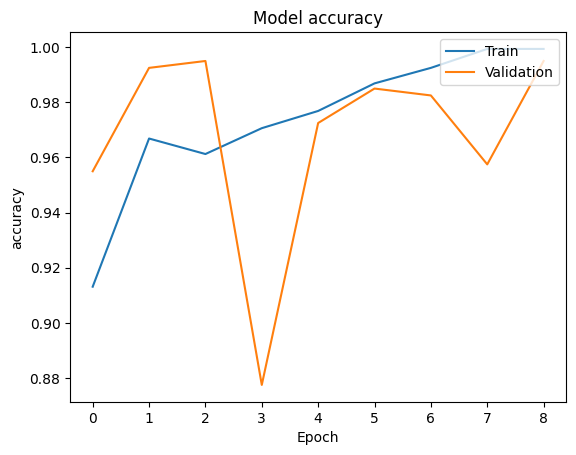

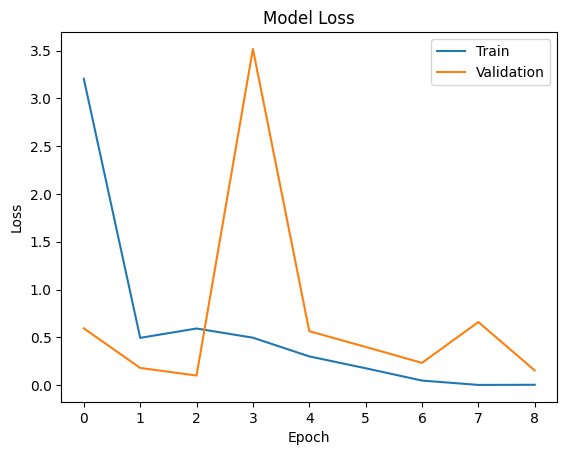

In [ ]:
import matplotlib.pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
model.save('resnet50v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Define the path where the model is saved in Google Drive
drive_path = '/content/drive/My Drive/'

# Load the model from Google Drive
from keras.models import load_model
model = load_model(drive_path + 'resnet50v2.h5')


In [ ]:
import os
import numpy as np
import cv2
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            if "COVID-" in filename:
                labels.append(1)  # COVID-19 Positive class
            elif "Normal-" in filename:
                labels.append(0)  # COVID-19 Negative class
    return images, labels
# Paths to folders containing images
covid_positive_folder_test = "/content/drive/MyDrive/main_project/Test/positive_masks"
covid_negative_folder_test = "/content/drive/MyDrive/main_project/Test/negative_masks"

# Load images and corresponding labels
covid_pos_images_test, covid_pos_labels_test = load_images_from_folder(covid_positive_folder_test)
covid_neg_images_test, covid_neg_labels_test = load_images_from_folder(covid_negative_folder_test)

# Convert lists to numpy arrays
covid_pos_images_test1 = np.array(covid_pos_images_test)
covid_neg_images_test1 = np.array(covid_neg_images_test)
covid_pos_labels_test1 = np.array(covid_pos_labels_test)
covid_neg_labels_test1 = np.array(covid_neg_labels_test)

# Save numpy arrays and labels to .npy files
#np.save('covid_positive_images_test.npy', covid_pos_images)
#np.save('covid_negative_images_test.npy', covid_neg_images)
#np.save('covid_positive_labels_test.npy', covid_pos_labels)
#np.save('covid_negative_labels_test.npy', covid_neg_labels)

# Combine positive and negative samples
all_images_test = np.concatenate((covid_pos_images_test1, covid_neg_images_test1), axis=0)
all_labels_test = np.concatenate((covid_pos_labels_test1, covid_neg_labels_test1), axis=0)


In [ ]:
from tensorflow.keras.models import load_model
from scipy import ndimage
drive_path = '/content/drive/My Drive/'
model = load_model(drive_path+'resnet50v2.h5')

# Define a function to resize numpy arrays
def resize_array(array, new_shape):
    return np.array([ndimage.zoom(img, (new_shape[0] / img.shape[0], new_shape[1] / img.shape[1], 1), order=1) for img in array])


# Resize input numpy arrays to match the desired shape
test_images_resized = resize_array(all_images_test, (224, 224))


# Ensure data is in the correct format
processed_images_test= test_images_resized.astype('float32') / 255.0

# Predict probabilities for the positive class
probabilities_positive = model.predict(processed_images_test)

# Set a threshold for classification (e.g., 0.5)
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
predicted_classes_test_binary = (probabilities_positive >threshold).astype('int')

# Ensure predicted classes are integers
predicted_classes_test_binary = predicted_classes_test_binary.flatten()
# Define your class labels
class_labels = ['COVID-19 negative', 'COVID-19 positive']


# Map predicted classes to labels
predicted_labels_test_binary = [class_labels[pred_class] for pred_class in predicted_classes_test_binary]

# Print the predicted labels for each image
for i in range(len(predicted_labels_test_binary)):
    print(f"Image {i + 1}: Predicted Class - {predicted_labels_test_binary[i]}")



1/1 [==============================] - 8s 8s/step
Image 1: Predicted Class - COVID-19 positive
Image 2: Predicted Class - COVID-19 positive
Image 3: Predicted Class - COVID-19 positive
Image 4: Predicted Class - COVID-19 positive
Image 5: Predicted Class - COVID-19 positive
Image 6: Predicted Class - COVID-19 positive
Image 7: Predicted Class - COVID-19 positive
Image 8: Predicted Class - COVID-19 positive
Image 9: Predicted Class - COVID-19 positive
Image 10: Predicted Class - COVID-19 positive
Image 11: Predicted Class - COVID-19 positive
Image 12: Predicted Class - COVID-19 positive
Image 13: Predicted Class - COVID-19 positive
Image 14: Predicted Class - COVID-19 positive
Image 15: Predicted Class - COVID-19 positive
Image 16: Predicted Class - COVID-19 negative
Image 17: Predicted Class - COVID-19 negative
Image 18: Predicted Class - COVID-19 negative
Image 19: Predicted Class - COVID-19 negative
Image 20: Predicted Class - COVID-19 negative
Image 21: Predicted Class - COVID-19 ne

In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
class_labels=['covid-19 positive','covid-19 negative']
# Generate classification report
print("Classification Report:")
print(classification_report(all_labels_test, predicted_classes_test_binary, target_names=class_labels))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels_test, predicted_classes_test_binary))


Classification Report:
                   precision    recall  f1-score   support

covid-19 positive       1.00      0.87      0.93        15
covid-19 negative       0.88      1.00      0.94        15

         accuracy                           0.93        30
        macro avg       0.94      0.93      0.93        30
     weighted avg       0.94      0.93      0.93        30

Confusion Matrix:
[[13  2]
 [ 0 15]]


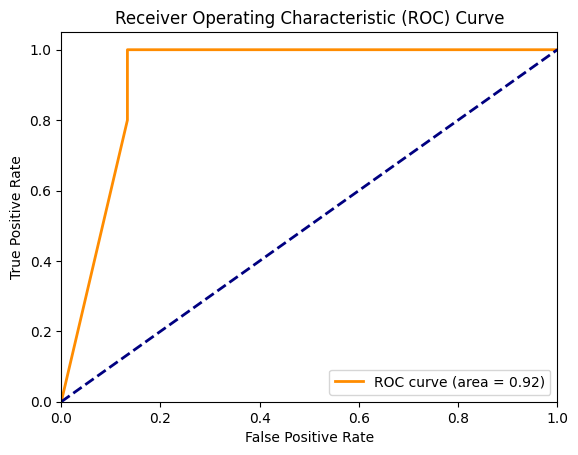

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have true labels for the test data stored in true_labels_test

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(all_labels_test, probabilities_positive)
roc_auc = auc(fpr, tpr)

# Assign values to tpr
tpr_values = tpr.flatten()  # Flatten the array if needed

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr_values, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Define the path where the model is saved in Google Drive
drive_path = '/content/drive/My Drive/'

# Load the model from Google Drive
from keras.models import load_model
model = load_model(drive_path + 'resnet50v2.h5')
import os
import numpy as np
import cv2
from scipy import ndimage


In [ ]:
import os
import numpy as np
import cv2
from scipy import ndimage
# Function to load images from a directory and convert them to numpy arrays
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            if "COVID-" in filename:
                labels.append(1)  # COVID-19 Positive class
            elif "Normal-" in filename:
                labels.append(0)  # COVID-19 Negative class
    return images, labels


# Paths to folders containing images
covid_positive_folder_test = "/content/drive/MyDrive/main_project/test2/covid_positive"
covid_negative_folder_test = "/content/drive/MyDrive/main_project/test2/covid_negative"

# Load images and corresponding labels
covid_pos_images_test, covid_pos_labels_test = load_images_from_folder(covid_positive_folder_test)
covid_neg_images_test, covid_neg_labels_test = load_images_from_folder(covid_negative_folder_test)

# Convert lists to numpy arrays
covid_pos_images_test1 = np.array(covid_pos_images_test)
covid_neg_images_test1 = np.array(covid_neg_images_test)
covid_pos_labels_test1 = np.array(covid_pos_labels_test)
covid_neg_labels_test1 = np.array(covid_neg_labels_test)

# Combine positive and negative samples
all_images_test = np.concatenate((covid_pos_images_test1, covid_neg_images_test1), axis=0)
all_labels_test = np.concatenate((covid_pos_labels_test1, covid_neg_labels_test1), axis=0)



# Define a function to resize numpy arrays
def resize_array(array, new_shape):
    return np.array([ndimage.zoom(img, (new_shape[0] / img.shape[0], new_shape[1] / img.shape[1], 1), order=1) for img in array])


# Resize input numpy arrays to match the desired shape
test_images_resized = resize_array(all_images_test, (224, 224))


# Ensure data is in the correct format
processed_images_test= test_images_resized.astype('float32') / 255.0

# Predict probabilities for the positive class
probabilities_positive = model.predict(processed_images_test)

# Set a threshold for classification
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
predicted_classes_test_binary = (probabilities_positive >threshold).astype('int')

# Ensure predicted classes are integers
predicted_classes_test_binary = predicted_classes_test_binary.flatten()
# Define your class labels
class_labels = ['COVID-19 negative', 'COVID-19 positive']


# Map predicted classes to labels
predicted_labels_test_binary = [class_labels[pred_class] for pred_class in predicted_classes_test_binary]

# Print the predicted labels for each image
for i in range(len(predicted_labels_test_binary)):
    print(f"Image {i + 1}: Predicted Class - {predicted_labels_test_binary[i]}")





2/2 [==============================] - 13s 6s/step
Image 1: Predicted Class - COVID-19 negative
Image 2: Predicted Class - COVID-19 positive
Image 3: Predicted Class - COVID-19 positive
Image 4: Predicted Class - COVID-19 positive
Image 5: Predicted Class - COVID-19 positive
Image 6: Predicted Class - COVID-19 positive
Image 7: Predicted Class - COVID-19 positive
Image 8: Predicted Class - COVID-19 positive
Image 9: Predicted Class - COVID-19 positive
Image 10: Predicted Class - COVID-19 positive
Image 11: Predicted Class - COVID-19 positive
Image 12: Predicted Class - COVID-19 positive
Image 13: Predicted Class - COVID-19 positive
Image 14: Predicted Class - COVID-19 positive
Image 15: Predicted Class - COVID-19 negative
Image 16: Predicted Class - COVID-19 positive
Image 17: Predicted Class - COVID-19 positive
Image 18: Predicted Class - COVID-19 positive
Image 19: Predicted Class - COVID-19 positive
Image 20: Predicted Class - COVID-19 positive
Image 21: Predicted Class - COVID-19 p

In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
class_labels=['covid-19 positive','covid-19 negative']
# Generate classification report
print("Classification Report:")
print(classification_report(all_labels_test, predicted_classes_test_binary, target_names=class_labels))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels_test, predicted_classes_test_binary))


Classification Report:
                   precision    recall  f1-score   support

covid-19 positive       0.88      1.00      0.94        30
covid-19 negative       1.00      0.87      0.93        30

         accuracy                           0.93        60
        macro avg       0.94      0.93      0.93        60
     weighted avg       0.94      0.93      0.93        60

Confusion Matrix:
[[30  0]
 [ 4 26]]


In [ ]:

# Define the path where you want to save the model in Google Drive
drive_path = '/content/drive/My Drive/'

# Save the model to Google Drive
model.save(drive_path + 'resnet50v2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Define the path where you want to save the model in Google Drive
drive_path = '/content/drive/My Drive/'



import joblib
from tensorflow.keras.models import load_model

# Load the .h5 model
model_h5 = load_model(drive_path+'resnet50v2.h5')

# Convert the model to byte stream using joblib
with open('model.pkl', 'wb') as file:
    joblib.dump(model_h5, file)


In [ ]:
import joblib
drive_path = '/content/drive/My Drive/'
model = load_model(drive_path + 'resnet50v2.h5')

# Serialize the model to a pickle file
joblib.dump(model, drive_path + 'resnet50v2.pkl')

['/content/drive/My Drive/resnet50v2.pkl']

In [ ]:
import pickle
import tensorflow as tf
drive_path = '/content/drive/My Drive/'

# Load the model from the .h5 file
model = tf.keras.models.load_model(drive_path +'resnet50v2.h5')

# Extract model weights and architecture
model_weights = model.get_weights()
model_config = model.get_config()

# Save weights and config as a .pkl file
with open('model.pkl', 'wb') as f:
    pickle.dump([model_weights, model_config], f)

In [ ]:
print(tf.__version__)

2.15.0
